## Introduction
In this project, we are trying to build a automate AB testing framework.


## Background
A worldwide e-commerce site wants to test whether a localized translation will increase the local conversion rate, comparing with the version written by a Spaniard. The result of their test is negative, and it appears that the non-localized translation was doing better!

## Tasks
- Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
- Explain why that might be happening. Are the localized translations really worse?
- If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

## Load packages and data


In [29]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pydotplus
import collections


In [30]:
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [31]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [32]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


Let's check if there is any duplicate data.
It seems that there is no duplicated data and the length of two tables are not equal. We should be careful it when join two tables.

In [33]:
print(len(test.user_id) == len(user.user_id))
print(len(test.user_id.unique()) == len(user.user_id))

False
False


In [34]:
sum(test.user_id.duplicated())

0

In [35]:
whole = pd.merge(test, user, how='left', on='user_id')
whole = whole[['user_id', 'date', 'sex', 'age', 'country', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test']]

## Analysis
Let's groupby our data by feature 'test' and 'country'.

In [36]:
result = whole.groupby(['test', 'country'], as_index=False, sort='country')['conversion'].agg({'NumCon':'sum', 'Total':'count', 'Rate':'mean'})

In [37]:
result

,test,country,NumCon,Total,Rate
0,0,Argentina,141,9356,0.015071
1,0,Bolivia,274,5550,0.049369
2,0,Chile,474,9853,0.048107
3,0,Colombia,1411,27088,0.052089
4,0,Costa Rica,139,2660,0.052256
5,0,Ecuador,395,8036,0.049154
6,0,El Salvador,220,4108,0.053554
7,0,Guatemala,386,7622,0.050643
8,0,Honduras,222,4361,0.050906
9,0,Mexico,3178,64209,0.049495


From the below table, we can see the output of groupby. One thing we should notice that the number of users in two groups of country Argentina and Uruguay is quite different. For others, we can consider them as 50/50.

First question is: check test results. But even before that, let’s make sure it is true Spain converts much better than the rest of LatAm countries.
From the below table, we can see that it is true.

In [38]:
result.loc[result.test==0, :].sort_values(by='Rate', ascending=False)

,test,country,NumCon,Total,Rate
14,0,Spain,4128,51782,0.079719
6,0,El Salvador,220,4108,0.053554
10,0,Nicaragua,180,3419,0.052647
4,0,Costa Rica,139,2660,0.052256
3,0,Colombia,1411,27088,0.052089
8,0,Honduras,222,4361,0.050906
7,0,Guatemala,386,7622,0.050643
16,0,Venezuela,813,16149,0.050344
13,0,Peru,842,16869,0.049914
9,0,Mexico,3178,64209,0.049495


Since Spain does't change anything, we delete it from them.
Then, first we do t-test for all countries together.
We can see from the following result, p-value is very small, and we can reject the null hypothesis. The confidence intercal is also calculated, which is \[-0.0062, -0.0036\]. It means that the performance of experiment group is worsen than control group.

In [39]:
m = stats.ttest_ind(whole.loc[(whole.country!='Spain')&(whole.test==1), 'conversion'],
                    whole.loc[(whole.country!='Spain')&(whole.test==0), 'conversion'],
                    equal_var=False)
print(m)

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


In [40]:
X_exp = sum(whole.loc[(whole.country!='Spain')&(whole.test==1), 'conversion'])
X_cot = sum(whole.loc[(whole.country!='Spain')&(whole.test==0), 'conversion'])
N_exp = len(whole.loc[(whole.country!='Spain')&(whole.test==1), 'conversion'])
N_cot = len(whole.loc[(whole.country!='Spain')&(whole.test==0), 'conversion'])

In [41]:
print(X_exp, X_cot, N_exp, N_cot)

9379 8968 215983 185556


In [42]:
p_pool = (X_exp + X_cot) / (N_exp + N_cot)
SE_pool = np.sqrt(p_pool*(1 - p_pool)*(1/N_exp + 1/N_cot))
d_hat = X_exp/N_exp - X_cot/N_cot
print('p_exp=', round(X_exp/N_exp, 4), 'p_co=', round(X_cot/N_cot, 4), 'diff=', round(d_hat, 4))

p_exp= 0.0434 p_co= 0.0483 diff= -0.0049


In [43]:
print(round(d_hat-1.96*SE_pool, 4), round(d_hat+1.96*SE_pool, 4))

-0.0062 -0.0036


We can see that it decreses almost 10%, which is unnormal. In data science, whenever results appear too bad or too good to be true, they are not true. Thus, we should dive into the data a little bit.

The first idea is that maybe we should do t-test seperately for each country, since different country may have different situation.
The below is the result. From it we can see that all of them are not significant. That' intersting, since it contradict the above analysis. Since the sample sizes for different countries are different, the idea of Simpson's paradox comes up.

In [44]:
countries_name = ['Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Ecuador',
 'El Salvador', 'Guatemala','Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay',
 'Peru', 'Venezuela', 'Argentina', 'Uruguay']

In [45]:
for col in countries_name:
    s,p = stats.ttest_ind(whole.loc[(whole.country==col)&(whole.test==1), 'conversion'],
                          whole.loc[(whole.country==col)&(whole.test==0), 'conversion'],
                          equal_var=False)
    print(col, ':', 'p-value=', p)

Bolivia : p-value= 0.7188852468451075
Chile : p-value= 0.30284764308444695
Colombia : p-value= 0.4237190741314115
Costa Rica : p-value= 0.6878763537073986
Ecuador : p-value= 0.9615116906006622
El Salvador : p-value= 0.2481266743266678
Guatemala : p-value= 0.5721072081912069
Honduras : p-value= 0.4714628565257586
Mexico : p-value= 0.16554372211039645
Nicaragua : p-value= 0.7804003858904794
Panama : p-value= 0.7053268372725889
Paraguay : p-value= 0.8836965034962364
Peru : p-value= 0.7719529885153548
Venezuela : p-value= 0.5737015234387255
Argentina : p-value= 0.3351465468746866
Uruguay : p-value= 0.8797639736514224


Another thing we can check is the distribution of the sample on the date.

In [46]:
result1 = whole.groupby(['test', 'date'], as_index=False)['conversion'].agg({'NumCon':'sum', 'Total':'count', 'Rate':'mean'})

In [47]:
result1

,test,date,NumCon,Total,Rate
0,0,2015-11-30,2131,37142,0.057374
1,0,2015-12-01,1990,37116,0.053616
2,0,2015-12-02,2054,37100,0.055364
3,0,2015-12-03,2921,52073,0.056094
4,0,2015-12-04,4000,73907,0.054122
5,1,2015-11-30,1487,33883,0.043886
6,1,2015-12-01,1402,33875,0.041387
7,1,2015-12-02,1484,33549,0.044234
8,1,2015-12-03,2081,47420,0.043884
9,1,2015-12-04,2925,67256,0.043491


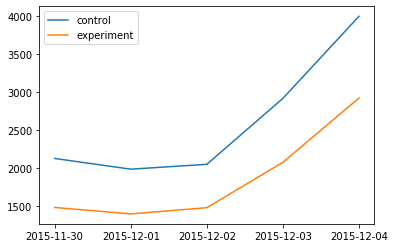

In [48]:
plt.plot(result1.date[result1.test==0], result1.NumCon[result1.test==0], label='control')
plt.plot(result1.date[result1.test==1], result1.NumCon[result1.test==1], label='experiment')
plt.legend()
plt.show()

Now, let's see if there is a sudden increasement.

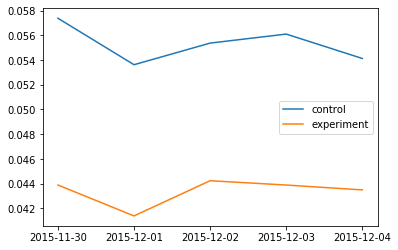

In [49]:
plt.plot(result1.date[result1.test==0], result1.Rate[result1.test==0], label='control')
plt.plot(result1.date[result1.test==1], result1.Rate[result1.test==1], label='experiment')
plt.legend()
plt.show()

From the above two plots, we can notice a couple of things:
- We just run the experiment for 5 days, and we always want to run a experiment for 2-3 weeks, in order to avoid the novelty and primacy effects and capture the effect of weekday and weekend.
- The distribution of data among time are not stable, we can see an increasement trend.
- However, for the conversion rate, the distribution of it is quite stable.


Now, it's time to find the bias. In an ideal world, the distribution of people in test and control for each segment should be the same. We can check it by several ways. One way can do this is building a decision tree and consider groups as target values.


In [50]:
whole.columns

Index(['user_id', 'date', 'sex', 'age', 'country', 'source', 'device',
       'browser_language', 'ads_channel', 'browser', 'conversion', 'test'],
      dtype='object')

In [51]:
X = whole[['sex', 'age', 'country', 'source', 'device',
       'browser_language', 'ads_channel', 'browser']]
y = whole[['test']]
lb = LabelEncoder()
for col in ['sex', 'country', 'source', 'device',
       'browser_language', 'ads_channel', 'browser']:
       X[col] = lb.fit_transform(X[col].tolist())

/Users/pinecone/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [52]:
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').